In [ ]:

import numpy as np
from DeepQLearning.generate_price_data import *
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from constructing_models import *

KeyboardInterrupt: 

Construct action space and plot the distribution of portfolio weights for each action

len: 5
shape a: (5,)
len: 5
shape a: (5,)
len: 5
shape a: (5,)
len: 5
shape a: (5,)
len: 5
shape a: (5,)


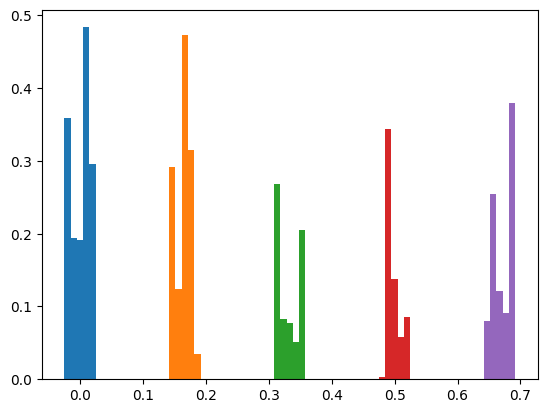

In [ ]:
a = 5 # size of action space
n = 5 # num asssets

# shape (n, a)
A = np.random.dirichlet(np.full(n, 1), a)
# rowsums are 1
fig, ax = plt.subplots() # x axis is actions (a)

width = 1 / (2 * a * n) - 0.01
gap = 0.01
offsets = (np.arange(a) - (a - 1) / 2) * width

n_even = n % 2 == 0

for i in range(a):

    c = i / (a + 1)

    xvalues1 = [c - i*gap for i in range(1, n // 2 + 1)]
    xvalues2 = [c + i*gap for i in range(1, n // 2 + 1)]
    print('len:', len(xvalues1) * 2 if n_even else len(xvalues1) * 2 + 1)
    print('shape a:', A[:, i].shape)
    if not n_even:
        ax.bar(xvalues1 + [c] + xvalues2, A[:, i], width=gap)    
    else:
        ax.bar(xvalues1 + xvalues2, A[:, i], width=gap)

plt.show()




Construct regime transition matrix and generate the regime sequence

In [ ]:

m = 3 # action space
M = np.array([
    [0.95, 0.05, 0.00],
    [0.06, 0.91, 0.03],
    [0.00, 0.12, 0.88]
])

init_regime_prob_dist = [0.7, 0.15, 0.15]

T = 1000
T_test = 200

regime = np.random.choice(range(m), p=init_regime_prob_dist)
true_regimes_total = np.empty(T + T_test, dtype=int)
true_regimes_total[0] = regime
for t in range(1, T + T_test):
    next_regime = np.random.choice(range(m), p=M[regime, :])
    true_regimes_total[t] = next_regime
    regime = next_regime

print(true_regimes_total)

[2 2 2 ... 1 1 1]


Generate synthetic data

97
color green: low vol
color yellow: medium vol
color red: high vol


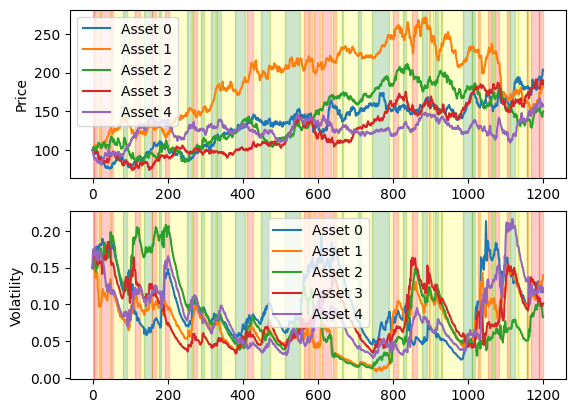

In [ ]:
price_data_total = np.empty((T + T_test, n))
volatility_data_total = np.empty((T + T_test, n))

xi_values = [0.05, 0.2, 0.6] # volatility of volatility
kappa_values = [6, 1.0, 0.5] # mean reversion rate
theta_values = [0.01, 0.2, 1.2] # mean volatility
mu_values = [0.0, 1.0, -1.0] # price drift

V0 = np.full(n, 0.15)
S0 = np.full(n, 100)

price_data_total = np.empty((T + T_test, n))
volatility_data_total = np.empty((T + T_test, n))

fig, (ax1, ax2) = plt.subplots(2)

x_breakpoints = []
x_breakpoints_labels = []

t = 0
while t < T + T_test:
    this_regime = true_regimes_total[t]
    tt = t + 1
    while tt < T + T_test:
        if true_regimes_total[tt] == this_regime:
            tt += 1
        else:
            break
    x_breakpoints.append(tt)
    x_breakpoints_labels.append(this_regime)
    volatility_data_total[t:tt, :] = np.array([
            generate_volatility(
                V0=V0[i],
                xi=xi_values[this_regime],
                theta=theta_values[this_regime],
                kappa=kappa_values[this_regime],
                N=tt - t,
                dt=1/365
            )
            for i in range(n)
        ]).T
    price_data_total[t:tt, :] = np.array([
        generate_prices(
            vola_values=volatility_data_total[t:tt, i],
            S0=S0[i],
            N=tt - t,
            mu=mu_values[this_regime],
            dt=1/365
    )
        for i in range(n)
    ]).T
    V0 = volatility_data_total[tt - 1, :]
    S0 = price_data_total[tt - 1, :]
    t = tt

x_breakpoints_labels.append(this_regime)
x_breakpoints.append(t)

price_data = price_data_total[:T]
price_data_eval = price_data_total[T:]
volatility_data = volatility_data_total[:T]
volatility_data_data_eval = volatility_data_total[T:]

for i in range(a):
    ax1.plot(range(T + T_test), price_data_total[:, i], label=f"Asset {i}")
    ax2.plot(range(T + T_test), volatility_data_total[:, i], label=f"Asset {i}")

ax1.legend()
ax2.legend()
ax1.set_ylabel("Price")
ax2.set_ylabel("Volatility")

colors = ["green", "yellow", "red"]
color_labels = ["low vol", "medium vol", "high vol"]

for i in range(len(x_breakpoints) - 1):
    ax1.axvspan(x_breakpoints[i],
                x_breakpoints[i + 1], color=colors[x_breakpoints_labels[i]],
                alpha=0.2)
    ax2.axvspan(x_breakpoints[i],
                x_breakpoints[i + 1], color=colors[x_breakpoints_labels[i]],
                alpha=0.2)

true_regimes = true_regimes_total[:T]
true_regimes_eval = true_regimes_total[T:]

ax1.axvspan(0, x_breakpoints[0], color=colors[true_regimes[0]], alpha=0.2)
ax2.axvspan(0, x_breakpoints[0], color=colors[true_regimes[0]], alpha=0.2)

print(len(x_breakpoints_labels))

for c, cl in zip(colors, color_labels):
    print(f"color {c}: {cl}")

plt.show()

General procedure:

For every timestep in the data:

-Feed $p\times v$ matrix, where $p$ is the lookback period and $v$ the feature dimension, to the model to obtain Q-values and use these values to determine next action to take.

-Determine the next state to be in when taking this action, and compute the reward.

-Store the information (reward, state, action taken) into the replay buffer.

-When past a certain threshold $t_{\text{current}}>t_{\text{threshold}}$, sample a random set from the replay buffer and use this for the model to learn, with the target Q-values being computed using the Bellman equation. Update the weights in the model for it to learn.

In [ ]:
total_returns = pd.DataFrame(price_data_total).pct_change(axis=0).to_numpy()
returns_train = total_returns[:T]
returns_train[0, :] = np.zeros(n)

print(returns_train)
print()
print(returns_train.shape)

[[ 0.          0.          0.          0.          0.        ]
 [-0.00364888  0.00494756  0.02101979 -0.01679945 -0.02554824]
 [ 0.0146274   0.00232359  0.0153977   0.00275765 -0.03485425]
 ...
 [ 0.01008363  0.01852601  0.01665674 -0.00835396  0.00537184]
 [ 0.00691671  0.00817477 -0.00705904  0.00836667  0.01153551]
 [ 0.00352334  0.01428148  0.0050027   0.00080059 -0.01187544]]

(1000, 5)


In [ ]:
# construct returns and volatility data 
vola_lookback = 15
mean_returns = np.mean(returns_train, axis=1)
vola = pd.Series(mean_returns).rolling(vola_lookback, min_periods=1).std().values
vola[0] = 0
rb_capacity = 1000
rb_sample_size = 5
gamma = 0.95
t_replay_buffer = 30
training_lookback_period = 15

# define DQN model
dqn = Model1(
    state_space=returns_train,
    rb_sample_size=rb_sample_size,
    gamma=gamma,
    rep_buffer_size=rb_capacity,
    action_space=A,
    training_lookback_period=training_lookback_period,
    t_replay_buffer=t_replay_buffer
)

eq_weights_return = returns_train @ np.full(n, 1/n)
eq_weights_return_cumsum = np.cumsum(eq_weights_return)

# train model and plot some statistics
losses, avg_q_values, rewards = dqn.train()
cum_rewards = np.cumsum(rewards)
fig, (ax1, ax2, ax3) = plt.subplots(3)

ax1.plot(losses)
ax2.plot(avg_q_values)
ax3.plot(cum_rewards, label="trained weights")
ax3.plot(eq_weights_return_cumsum, label="equal weights")
ax3.legend()
plt.show()





NameError: name 'np' is not defined